# COMP 551 Assignment 2

## Task 1: Acquire the data

In [ ]:
import torch as t
import torchvision as tv
import numpy as np
# import cupy as np
import matplotlib.pyplot as plt
import warnings
import math

# to suppress warnings
warnings.filterwarnings("ignore")

dir = "./data"

### Dataset 1: Fashion MNIST

60000
10000
Ankle boot T-shirt/top T-shirt/top Dress T-shirt/top Pullover Sneaker Pullover


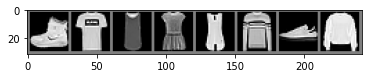

In [ ]:
# Don't forget to include normalization
mnist_transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5), (0.5))])

mnist_train_df = tv.datasets.FashionMNIST(root=dir, train=True, transform=mnist_transform, download=True)
mnist_test_df = tv.datasets.FashionMNIST(root=dir, train=False, transform=mnist_transform, download=True)

# see the size of data
print(len(mnist_train_df))
print(len(mnist_test_df))
# trainset: 60000, testset: 10000

# hardcode the classes of MNIST dataset
mnist_class = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# extract some sample from the dataset and see the pictures
mnist_sample = 8
mnist_sample_loader = t.utils.data.DataLoader(mnist_train_df, batch_size=mnist_sample, shuffle=False)

# for convenience, write a show picture function (for grayscale pictures)
def show_grey_img(img, denormalize=True):
    if denormalize:
        img = img / 2 + 0.5
    npimg = img.numpy()
    # adjust the shape (permute the axis) to show image
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap='gray')

mnist_imgiter = iter(mnist_sample_loader)
mnist_img, mnist_lbl = next(mnist_imgiter)
show_grey_img(tv.utils.make_grid(mnist_img))
print(' '.join(f'{mnist_class[mnist_lbl[i]]}' for i in range(mnist_sample)))
# note that FashionMNIST images are (channel 1x) 28 x 28

### Dataset 2: CIFAR-10

Files already downloaded and verified
Files already downloaded and verified
50000
10000


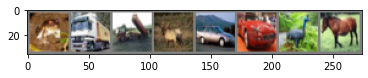

frog truck truck deer car car bird horse


In [ ]:
# Don't forget to include normalization
cifar_transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train_df = tv.datasets.CIFAR10(root=dir, train=True, transform=cifar_transform, download=True)
cifar_test_df = tv.datasets.CIFAR10(root=dir, train=False, transform=cifar_transform, download=True)

# see the size of data
print(len(cifar_train_df))
print(len(cifar_test_df))
# trainset: 50000, testset: 10000

# hardcode the classes of CIFAR dataset
cifar_class = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

# extract some sample from the dataset and see the pictures
cifar_sample = 8
cifar_sample_loader = t.utils.data.DataLoader(cifar_train_df, batch_size=cifar_sample, shuffle=False)

# for convenience, write a show picture function (for rgb pictures)
def show_img(img, denormalize=True):
    if denormalize:
        img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

cifar_imgiter = iter(cifar_sample_loader)
cifar_img, cifar_lbl = next(cifar_imgiter)
show_img(tv.utils.make_grid(cifar_img))
print(' '.join(f'{cifar_class[cifar_lbl[i]]}' for i in range(cifar_sample)))
# note that CIFAR images are (channel 3x) 32 x 32

## Task 2: Implement a Multilayer Perceptron (MLP)

In [ ]:
class MLP:
    # both our dataset has 10 classes, so by default C = 10
    def __init__(self, ac, ac_derivative, loss = 'cross',C=10, hidden=2, units=[128, 128], initializer="kaiming", regularization=0, regularization_coeff=0.001,valid_step = 5):
        assert len(units) == hidden
        self.ac = ac
        self.ac_derivative = ac_derivative
        self.C = C
        self.hidden = hidden
        self.units = units
        self.initializer = initializer
        self.regularization = regularization
        self.regularization_coeff = regularization_coeff
        self.loss = loss
        self.valid_step = valid_step
        np.random.seed(33)

    def param_init(self, X):
        N, D = X.shape
        # in our implementation of MLP, we treat weights and biases seperately (instead of attaching a new column to every matrix)
        self.weights = []
        self.biases = []
        if self.initializer == "zero":
            for i in range(self.hidden + 1):
                # get the row and column number for each matrix
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                self.weights.append(np.zeros((row, column)))
                self.biases.append(np.zeros(column))
        if self.initializer == "uniform":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                self.weights.append(np.random.uniform(-1, 1, (row, column)))
                self.biases.append(np.random.uniform(-1, 1, column))
        if self.initializer == "gaussian":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                self.weights.append(np.random.randn(row, column))
                self.biases.append(np.random.randn(column))
        if self.initializer == "xavier":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                # note that xavier initialization: Unif[-1/sqrt(n), 1/sqrt(n)] where n = input feature size
                hi = 1 / np.sqrt(row)
                self.weights.append(np.random.uniform(-hi, hi, (row, column)))
                self.biases.append(np.random.uniform(-hi, hi, column))
        if self.initializer == "normalized xavier":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                # note that normalized xavier initialization: Unif[-a, a] where a = sqrt(3) / sqrt(input feature size)
                stddev = 1.0 / np.sqrt(row)
                limit = np.sqrt(3) * stddev
                self.weights.append(np.random.uniform(-limit, limit, (row, column)))
                self.biases.append(np.random.uniform(-limit, limit, column))
        if self.initializer == "kaiming":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                # note that kaiming initialization: N(0, 2/n) where n = input feature size
                variance = 2 / row
                self.weights.append(np.random.randn(row, column) * np.sqrt(variance))
                self.biases.append(np.zeros(column))

    # need to apply softmax for last layer's activation
    def softmax(self, a):
        # to avoid overflow:
        e = np.exp(a - np.max(a))
        return e / np.sum(e, axis=1, keepdims=True)

    def calculate_loss(self, predictions, y):
        # expect predictions to be 1d (not probabilities)
        assert len(y) == len(predictions)
        if y.ndim == 1:
            y = np.eye(self.C)[y]
        N, C = y.shape
        return -1 * np.sum(y * np.log(predictions)) / N

    def calculate_accuracy(self, predictions, y):
        # expect predictions to be 1d, y to be 1d
        assert len(y) == len(predictions)
        correct = np.count_nonzero(y == predictions)
        accuracy = correct / len(y)
        return accuracy

    def calculate_metric_given_X(self, X, y):
        # expect X to be N x D, y to be N x 1 (real data and labels)
        raw = self.predict(X, raw=True)
        predictions = np.argmax(raw, axis=1)
        loss = self.calculate_loss(raw, y)
        accuracy = self.calculate_accuracy(predictions, y)
        return loss, accuracy

    def forward(self, X):
                              # X: N x Features[0] (= 28 x 28 x 1 or 32 x 32 x 3)
        activations = [X]     # after applying activations
        z_values = []         # z-values: z = Xw (before applying activations)

        for i in range(len(self.weights)):                              # using i = 0:
            z = activations[-1] @ self.weights[i] + self.biases[i]      # weights[0]: Features[0] x Features[1] (= units[0])
                                                                        # biases[0]: 1 x Features[1] (add for each row)
            X = self.ac(z)                                              # X for next pass: N x Features[1]
            activations.append(X)
            z_values.append(z)
        return activations, z_values

    # Note that in our model, we also apply activation on the last layer's z, which is different that that in the slides.
    # That is, our yhat = softmax(f(z)) where f is the activation; in the slides it's yhat = softmax(z).

    def backward(self, X, y, lr, activations, z_values, forwarded=False):
        # add new parameter activations, z-value and forwarded, to avoid reduntantly running it inside fit function.
        N, D = X.shape
        if not forwarded:
            activations, z_values = self.forward(X)      # activation[-1]: N x C
        y_hat = self.softmax(activations[-1])            # yhat: N x C

        # simplified dL/da
        dL_da = y_hat - y                                # N x C
        dL_dz = dL_da * self.ac_derivative(z_values[-1]) # N x C

        deltas = [dL_dz]
        for i in range(self.hidden - 1, -1, -1):
            delta = (deltas[-1] @ self.weights[i+1].T) * self.ac_derivative(z_values[i])
            # print(delta)
                                                         # using i = self.hidden - 1:
                                                         # deltas[-1] = dL/dz: N x C
                                                         # self.weights[self.hidden] = units[-1] x C
                                                         # deltas[-1] * self.weights[i+1].T = dL/da_prev: N x units[-1]
            deltas.append(delta)
        # reverse deltas for convenience
        deltas = deltas[::-1]
        for i in range(self.hidden + 1):
            if self.regularization == 0:
                self.weights[i] -= lr * (activations[i].T @ deltas[i]) / N
                                                         # using i = self.hidden:
                                                         # length of activations is 2 + self.hidden, length of deltas is 1 + self.hidden
                                                         # activations[self.hidden]: N x units[-1]
                                                         # deltas[self.hidden]: N x C
                                                         # activation[i].T @ deltas[i]: units[-1] x C == weights[self.hidden]
                self.biases[i] -= lr * np.sum(deltas[i], axis=0) / N
            if self.regularization == 1:
                # similar, but with regularization loss' update
                self.weights[i] -= lr * ((activations[i].T @ deltas[i]) / N + self.regularization_coeff * np.sign(self.weights[i]))
                self.biases[i] -= lr * (np.sum(deltas[i], axis=0) / N + self.regularization_coeff * np.sign(self.biases[i]))
            if self.regularization == 2:
                self.weights[i] -= lr * ((activations[i].T @ deltas[i]) / N + 2 * self.regularization_coeff * self.weights[i])
                self.biases[i] -= lr * (np.sum(deltas[i], axis=0) / N + 2 * self.regularization_coeff * self.biases[i])

    def pad_data(self,data, target_size, padding_value=0):
        padding_size = target_size - len(data)
        if padding_size > 0:
            padding = np.full((padding_size,) + data.shape[1:], padding_value)
            data_padded = np.concatenate([data, padding], axis=0)
        else:
            data_padded = data
        return data_padded

    def fit(self, X, y, lr=0.01, batchsize=64, epochs=100, grad=True, val_X=None, val_y=None):
        # expected parameters:
        # X: N x D matrix, y: N x 1 vector
        self.param_init(X)

        y_one_hot = np.eye(self.C)[y]               # one-hot encode y
        N, D = X.shape
        # record the loss and accuracy per step
        loss_per_step = []
        regularization_loss_per_step = []
        accuracy_per_step = []
        val_loss_per_step = []
        val_accuracy_per_step = []
        # Apply SGD:
        for epoch in range(epochs):
            # randomly permute the data
            indices = np.random.permutation(N)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            y_one_hot_shuffled = y_one_hot[indices]
            # Pad the last batch
            # if len(X_batch) < batchsize:
            #     X_batch = self.pad_data(X_batch, batchsize)
            #     y_batch = self.pad_data(y_batch, batchsize)
            #     y_one_hot_batch = self.pad_data(y_one_hot_batch, batchsize)

            for i in range(0, N, batchsize):
                # get current batch
                end_idx = min(i+batchsize, N)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                y_one_hot_batch = y_one_hot_shuffled[i:end_idx]

                # Calculate the current length of the dataset
                current_batch_size = len(X_batch)

                # Check if we need to pad
                if current_batch_size < batchsize:
                    X_batch = self.pad_data(X_batch, batchsize)
                    y_batch = self.pad_data(y_batch, batchsize)
                    y_one_hot_batch = self.pad_data(y_one_hot_batch, batchsize)

                activations, z_values = self.forward(X_batch)
                probabilities = self.softmax(activations[-1])
                predictions = np.argmax(probabilities, axis=1)

                if current_batch_size < batchsize:
                    predictions = predictions[:current_batch_size]
                    probabilities = probabilities[:current_batch_size]
                    y_batch = y_batch[:current_batch_size]

                # calculate regularization loss
                regularization_loss = 0
                if self.regularization == 1:
                    for _, matrix in enumerate(self.weights):
                        regularization_loss += np.sum(np.absolute(matrix))
                    for _, vector in enumerate(self.biases):
                        regularization_loss += np.sum(np.absolute(vector))
                if self.regularization == 2:
                    for _, matrix in enumerate(self.weights):
                        regularization_loss += np.linalg.norm(matrix, ord='fro') ** 2
                    for _, vector in enumerate(self.biases):
                        regularization_loss += np.linalg.norm(vector) ** 2

                regularization_loss_per_step.append(regularization_loss * self.regularization_coeff / N)
                loss_per_step.append(self.calculate_loss(probabilities, y_batch))
                accuracy_per_step.append(self.calculate_accuracy(predictions, y_batch))
                # note that the update step is not dependent on the regularization loss value
                if grad:
                    self.backward(X_batch, y_one_hot_batch, lr, activations, z_values, True)
            if val_X is not None and val_y is not None and (epoch+1) % self.valid_step == 0:
                val_loss, val_accuracy = self.validate(val_X, val_y)
                val_loss_per_step.append(val_loss)
                val_accuracy_per_step.append(val_accuracy)

        return loss_per_step, regularization_loss_per_step, accuracy_per_step, val_loss_per_step, val_accuracy_per_step


    def predict(self, X, raw=False):
        activations, _ = self.forward(X)
        predictions = self.softmax(activations[-1])
        if raw:
            return predictions
        y_pred = np.argmax(predictions, axis=1)
        return y_pred

    def train(self, X_train, y_train, lr=0.01, batchsize=256, epochs=1000):
        return self.fit(X_train, y_train, lr, batchsize, epochs)

    def validate(self, X_val, y_val):
        loss, accuracy = self.calculate_metric_given_X(X_val, y_val)
        return loss, accuracy

    def test(self, X_test, y_test):
        loss, accuracy = self.calculate_metric_given_X(X_test, y_test)
        return loss, accuracy

## Task 3: Run the experiments and report

### Subtask 3.1: Test the model's performance under different initializations

In [ ]:
# define ReLU function and its derivative, so we can pass it to our MLP class
def ReLU(x):
    return np.maximum(x, 0)

def ReLU_derivative(x):
    return np.where(x >= 0, 1, 0)

#### Revised data input

In [ ]:
from torch.utils.data import random_split

# split the dataset into train, validation and test set (which are all subset of the original train dataset, we did not use the original test data set)
train_size = int(0.7 * len(mnist_train_df))
valid_size = int(0.2 * len(mnist_train_df))
test_size = len(mnist_train_df) - train_size - valid_size
mnist_train_dataset, mnist_valid_dataset, mnist_test_dataset = random_split(mnist_train_df, [train_size, valid_size, test_size])

# get data loaders, iterators, and extract the dataset
mnist_train_loader = t.utils.data.DataLoader(mnist_train_dataset, batch_size=train_size, shuffle=True)
mnist_valid_loader = t.utils.data.DataLoader(mnist_valid_dataset, batch_size=valid_size, shuffle=False)
mnist_test_loader = t.utils.data.DataLoader(mnist_test_dataset, batch_size=test_size, shuffle=False)

mnist_X_train, mnist_y_train = next(iter(mnist_train_loader))
mnist_X_valid, mnist_y_valid = next(iter(mnist_valid_loader))
mnist_X_test, mnist_y_test = next(iter(mnist_test_loader))

mnist_X_train = np.asarray(mnist_X_train).reshape((train_size, -1))
mnist_y_train = np.asarray(mnist_y_train)
mnist_X_valid = np.asarray(mnist_X_valid).reshape((valid_size, -1))
mnist_y_valid = np.asarray(mnist_y_valid)
mnist_X_test = np.asarray(mnist_X_test).reshape((test_size, -1))
mnist_y_test = np.asarray(mnist_y_test)

#### Benchmarking

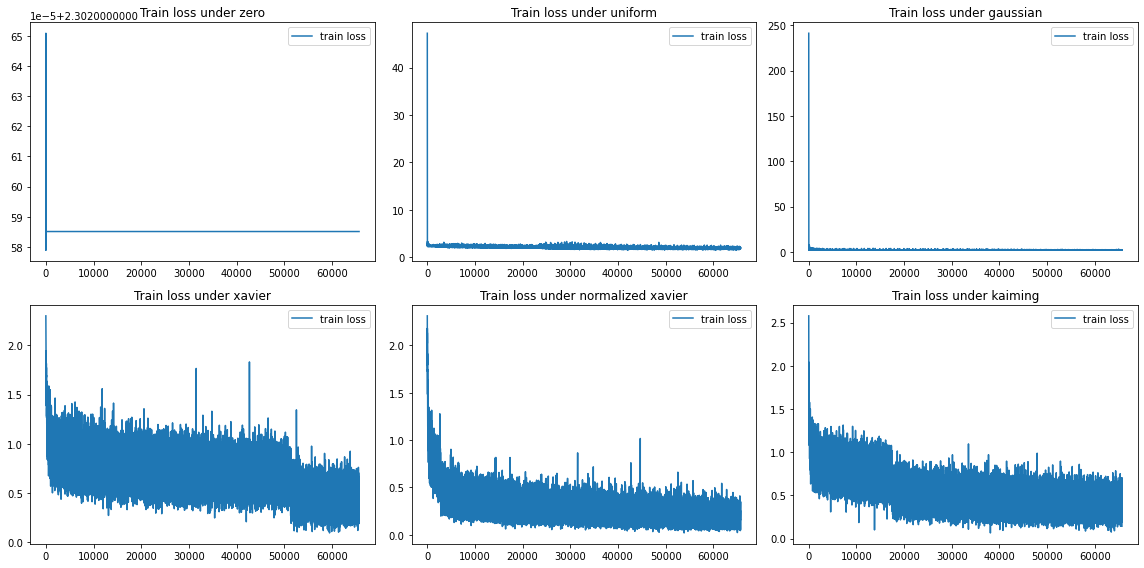

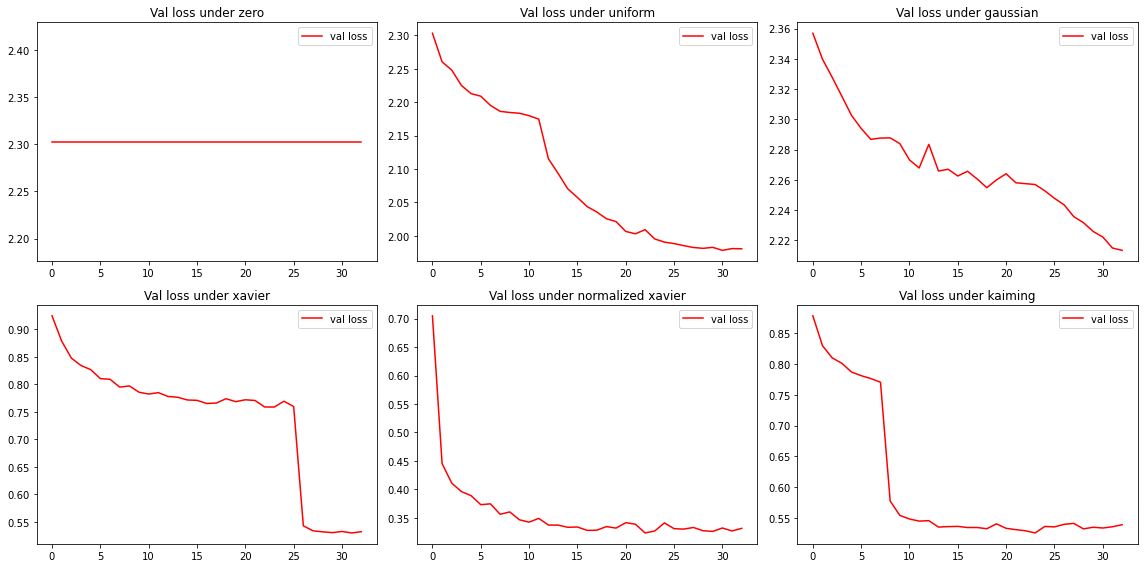

Test accuracy with zero initializer: 0.1025
Test accuracy with uniform initializer: 0.2705
Test accuracy with gaussian initializer: 0.18066666666666667
Test accuracy with xavier initializer: 0.815
Test accuracy with normalized xavier initializer: 0.8836666666666667
Test accuracy with kaiming initializer: 0.8031666666666667


In [ ]:
# there was some problem with using cupy... so we did not use GPU for our MLP, but CPU with multi-threading
from joblib import Parallel, delayed

# a helper function for evaluating the model
def train_and_test(i):
    init = initializers[i]
    model = MLP(ReLU, ReLU_derivative, hidden=1, units=[128], initializer=init,valid_step = 3)
    losses, _, _, val_losses, val_accuracies = model.fit(mnist_X_train, mnist_y_train, lr=0.01, epochs=100, val_X=mnist_X_valid, val_y=mnist_y_valid)
    _, test_accuracy = model.test(mnist_X_test, mnist_y_test)
    return losses, val_losses, test_accuracy

initializers = ["zero", "uniform", "gaussian", "xavier", "normalized xavier", "kaiming"]
results = Parallel(n_jobs=6)(delayed(train_and_test)(i) for i in range(6))

# get the performance of model under different initializations, and plot them
losses = [result[0] for result in results]
val_losses = [result[1] for result in results]
accuracies = [result[2] for result in results]

plt.figure(figsize=(16, 8))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i], label='train loss')
    p.set_title("Train loss under {0}".format(initializers[i]))
    p.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(val_losses[i], label='val loss', color='red')
    p.set_title("Val loss under {0}".format(initializers[i]))
    p.legend()
plt.tight_layout()
plt.show()

for i, acc in enumerate(accuracies):
    print(f"Test accuracy with {initializers[i]} initializer: {acc}")

### Subtask 3.2: Test the model's performance under different depth

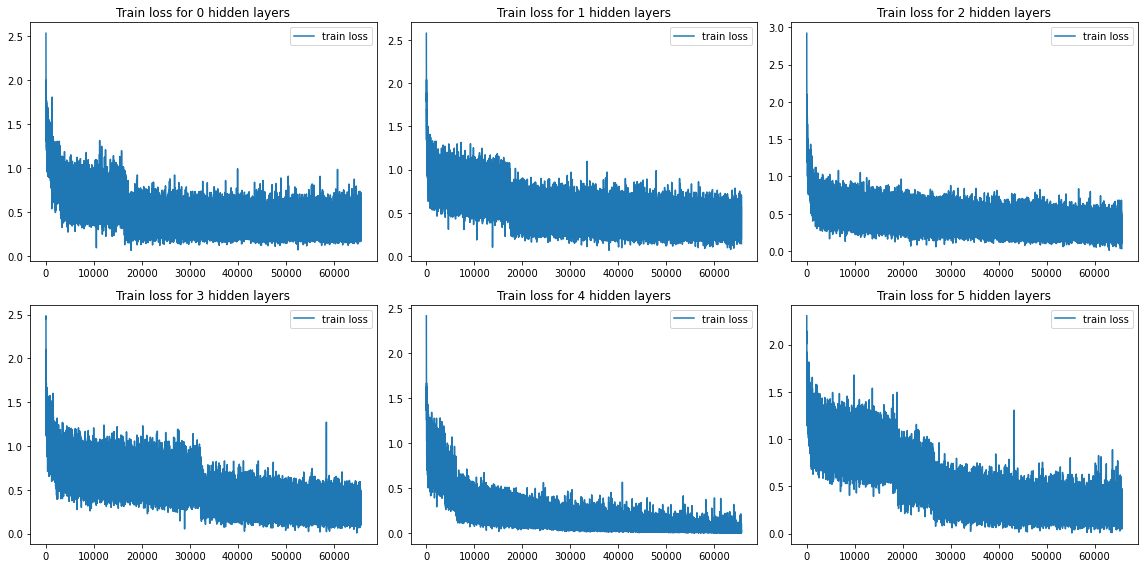

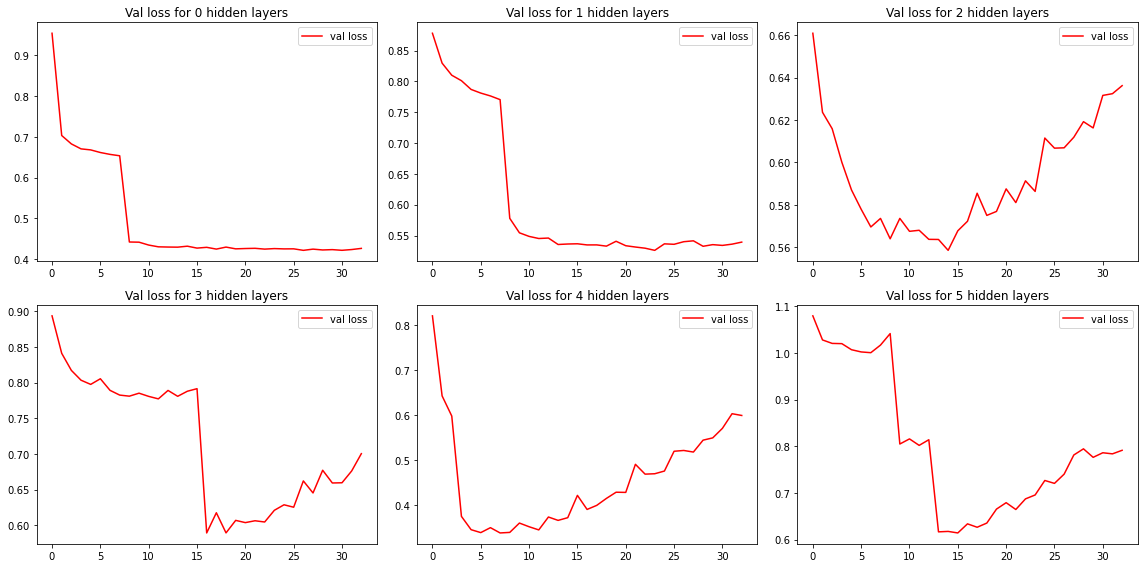

Test accuracy with 0 hidden layers: 0.8511666666666666, Test loss with 0 hidden layers: [0.43441891509475894, 0.5525611152382703, 0.6289980366322829, 0.6973314789403413, 0.5996440901130246, 0.8670074524911568]
Test accuracy with 1 hidden layers: 0.8031666666666667, Test loss with 1 hidden layers: [0.43441891509475894, 0.5525611152382703, 0.6289980366322829, 0.6973314789403413, 0.5996440901130246, 0.8670074524911568]
Test accuracy with 2 hidden layers: 0.7896666666666666, Test loss with 2 hidden layers: [0.43441891509475894, 0.5525611152382703, 0.6289980366322829, 0.6973314789403413, 0.5996440901130246, 0.8670074524911568]
Test accuracy with 3 hidden layers: 0.7826666666666666, Test loss with 3 hidden layers: [0.43441891509475894, 0.5525611152382703, 0.6289980366322829, 0.6973314789403413, 0.5996440901130246, 0.8670074524911568]
Test accuracy with 4 hidden layers: 0.881, Test loss with 4 hidden layers: [0.43441891509475894, 0.5525611152382703, 0.6289980366322829, 0.6973314789403413, 0.5

In [ ]:
from joblib import Parallel, delayed

def train_and_test(i):
    model = MLP(ReLU, ReLU_derivative, hidden=i, units=[128] * i, initializer="kaiming",valid_step=3)
    losses, _, _, val_losses, val_accuracies = model.fit(mnist_X_train, mnist_y_train, lr=0.01, epochs=100, val_X=mnist_X_valid, val_y=mnist_y_valid)
    test_loss, test_accuracy = model.test(mnist_X_test, mnist_y_test)
    return losses, val_losses, test_accuracy, test_loss

results = Parallel(n_jobs=6)(delayed(train_and_test)(i) for i in range(6))

losses = [result[0] for result in results]
val_losses = [result[1] for result in results]
accuracies = [result[2] for result in results]
test_losses = [result[3] for result in results]
plt.figure(figsize=(16, 8))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i], label='train loss')
    p.set_title("Train loss for {} hidden layers".format(i))
    p.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(val_losses[i], label='val loss', color='red')
    p.set_title("Val loss for {} hidden layers".format(i))
    p.legend()
plt.tight_layout()
plt.show()

for i, acc in enumerate(accuracies):
    print(f"Test accuracy with {i} hidden layers: {acc}, Test loss with {i} hidden layers: {test_losses}")

### Subtask 3.3: Test the performance of model with different activations

In [ ]:
# we will test some other activations:
def logistic(x):
    return 1 / (np.exp(-x) + 1)

def logistic_derivative(x):
    tmp = np.exp(-x)
    return tmp / (1 + tmp) ** 2

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - tanh(x) ** 2

def leaky_ReLU(x):  # gamma = 0.01
    return np.maximum(x, 0) + np.minimum(0, x) * 0.01

def leaky_ReLU_derivative(x):
    return np.where(x >= 0, 1, 0.01)

def softplus(x):
    return np.log1p(np.exp(x))

def softplus_derivative(x):
    tmp = np.exp(x)
    return tmp / (1 + tmp)

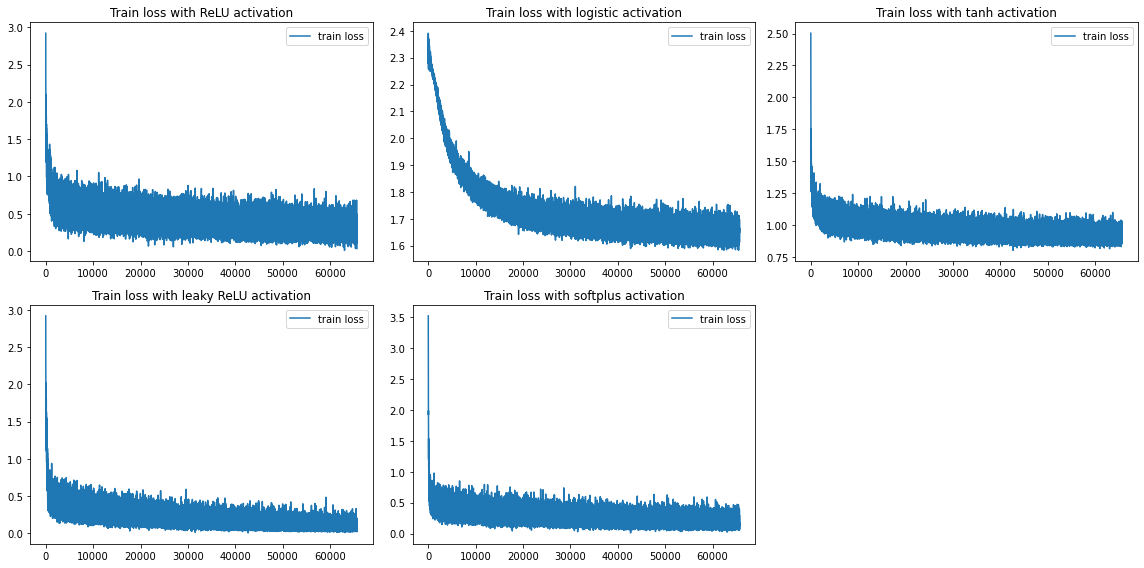

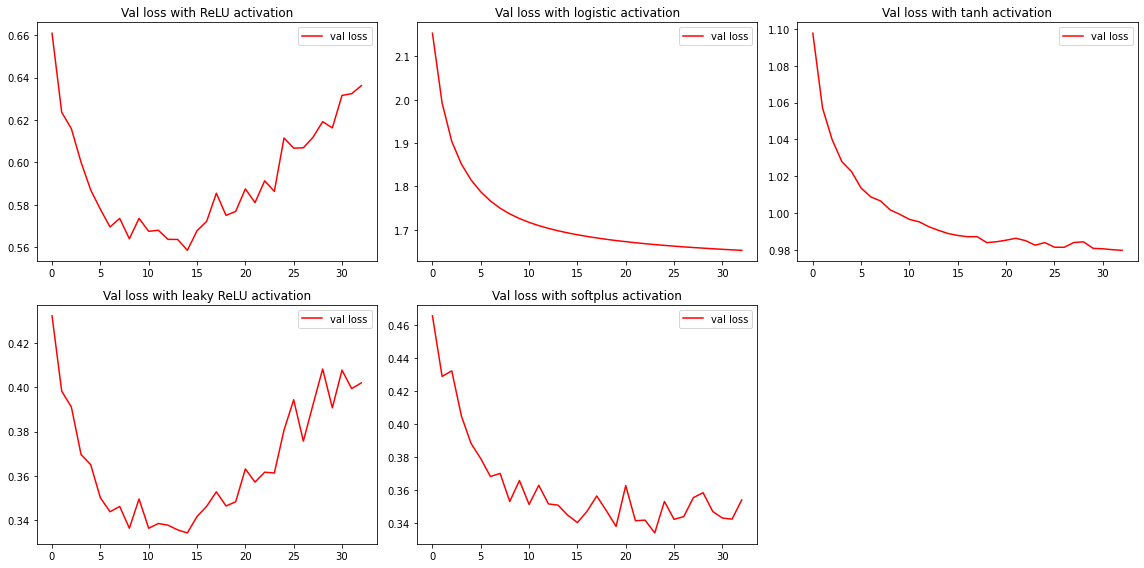

Test accuracy with ReLU activation: 0.7896666666666666
Test accuracy with logistic activation: 0.587
Test accuracy with tanh activation: 0.876
Test accuracy with leaky ReLU activation: 0.8781666666666667
Test accuracy with softplus activation: 0.8825


In [ ]:
from joblib import Parallel, delayed

def train_and_test(i):
    activation = activations[i]
    activation_derivative = activation_derivatives[i]
    model = MLP(activation, activation_derivative, hidden=2, units=[128, 128], initializer="kaiming",valid_step=3)
    losses, _, _, val_losses, val_accuracies = model.fit(mnist_X_train, mnist_y_train,lr = 0.01, epochs=100, val_X=mnist_X_valid, val_y=mnist_y_valid)
    _, test_accuracy = model.test(mnist_X_test, mnist_y_test)
    return losses, val_losses, test_accuracy

activations = [ReLU, logistic, tanh, leaky_ReLU, softplus]
activation_derivatives = [ReLU_derivative, logistic_derivative, tanh_derivative, leaky_ReLU_derivative, softplus_derivative]
names = ["ReLU", "logistic", "tanh", "leaky ReLU", "softplus"]

results = Parallel(n_jobs=5)(delayed(train_and_test)(i) for i in range(5))

losses = [result[0] for result in results]
val_losses = [result[1] for result in results]
accuracies = [result[2] for result in results]

plt.figure(figsize=(16, 8))
for i in range(5):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i], label='train loss')
    p.set_title("Train loss with {} activation".format(names[i]))
    p.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i in range(5):
    p = plt.subplot(2, 3, i+1)
    p.plot(val_losses[i], label='val loss', color='red')
    p.set_title("Val loss with {} activation".format(names[i]))
    p.legend()
plt.tight_layout()
plt.show()

for i, acc in enumerate(accuracies):
    print(f"Test accuracy with {names[i]} activation: {acc}")

### Subtask 3.4: Test the model's performance after adding regularization (L1, L2)

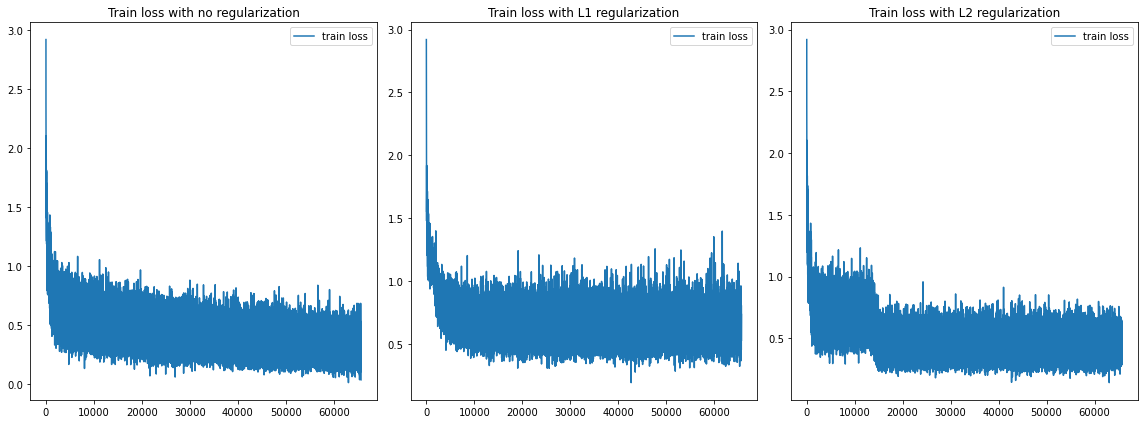

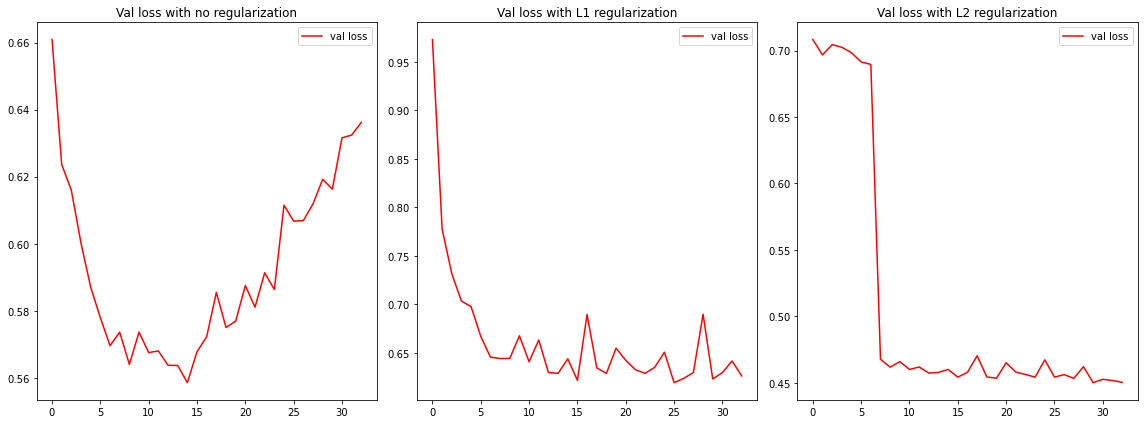

Test accuracy with no regularization: 0.7896666666666666
Test accuracy with L1 regularization: 0.7725
Test accuracy with L2 regularization: 0.8368333333333333


In [ ]:
from joblib import Parallel, delayed

def train_and_test(i):
    model = MLP(ReLU, ReLU_derivative, regularization=i, regularization_coeff=0.01,valid_step=3)
    losses, regu_losses, _, val_losses, val_accuracies = model.fit(mnist_X_train, mnist_y_train, epochs=100, val_X=mnist_X_valid, val_y=mnist_y_valid)
    _, test_accuracy = model.test(mnist_X_test, mnist_y_test)
    return losses, regu_losses, val_losses, test_accuracy

regularizations = [0, 1, 2]
names = ["no regularization", "L1 regularization", "L2 regularization"]

results = Parallel(n_jobs=3)(delayed(train_and_test)(i) for i in range(3))

losses = [result[0] for result in results]
regu_losses = [result[1] for result in results]
val_losses = [result[2] for result in results]
accuracies = [result[3] for result in results]

plt.figure(figsize=(16, 6))
for i in range(3):
    p = plt.subplot(1, 3, i+1)
    p.plot(np.add(losses[i], regu_losses[i]), label='train loss')
    p.set_title("Train loss with {}".format(names[i]))
    p.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
for i in range(3):
    p = plt.subplot(1, 3, i+1)
    p.plot(val_losses[i], label='val loss', color='red')
    p.set_title("Val loss with {}".format(names[i]))
    p.legend()
plt.tight_layout()
plt.show()

for i, acc in enumerate(accuracies):
    print(f"Test accuracy with {names[i]}: {acc}")

### Subtask 3.5: Test the model's performance if the input is not normalized

#### Data input

In [ ]:
# note the difference: this time we don't use Normalize()
mnist_transform_nonorm = tv.transforms.Compose([tv.transforms.ToTensor()])
# mnist_transform_nonorm = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5), (0.5))])

mnist_train_df_nonorm = tv.datasets.FashionMNIST(root=dir, train=True, transform=mnist_transform_nonorm, download=True)
mnist_test_df_nonorm = tv.datasets.FashionMNIST(root=dir, train=False, transform=mnist_transform_nonorm, download=True)

train_size_nonorm = int(0.7 * len(mnist_train_df_nonorm))
valid_size_nonorm = int(0.2 * len(mnist_train_df_nonorm))
test_size_nonorm = len(mnist_train_df_nonorm) - train_size_nonorm - valid_size_nonorm
mnist_train_dataset_nonorm, mnist_valid_dataset_nonorm, mnist_test_dataset_nonorm = random_split(mnist_train_df_nonorm, [train_size_nonorm, valid_size_nonorm, test_size_nonorm])

mnist_train_loader_nonorm = t.utils.data.DataLoader(mnist_train_dataset_nonorm, batch_size=train_size_nonorm, shuffle=True)
mnist_valid_loader_nonorm = t.utils.data.DataLoader(mnist_valid_dataset_nonorm, batch_size=valid_size_nonorm, shuffle=False)
mnist_test_loader_nonorm = t.utils.data.DataLoader(mnist_test_dataset_nonorm, batch_size=test_size_nonorm, shuffle=False)

mnist_X_train_nonorm, mnist_y_train_nonorm = next(iter(mnist_train_loader_nonorm))
mnist_X_valid_nonorm, mnist_y_valid_nonorm = next(iter(mnist_valid_loader_nonorm))
mnist_X_test_nonorm, mnist_y_test_nonorm = next(iter(mnist_test_loader_nonorm))
mnist_X_train_nonorm = np.asarray(mnist_X_train_nonorm).reshape((train_size_nonorm, -1))
mnist_y_train_nonorm = np.asarray(mnist_y_train_nonorm)
mnist_X_valid_nonorm = np.asarray(mnist_X_valid_nonorm).reshape((valid_size_nonorm, -1))
mnist_y_valid_nonorm = np.asarray(mnist_y_valid_nonorm)
mnist_X_test_nonorm = np.asarray(mnist_X_test_nonorm).reshape((test_size_nonorm, -1))
mnist_y_test_nonorm = np.asarray(mnist_y_test_nonorm)

#### Benchmarking

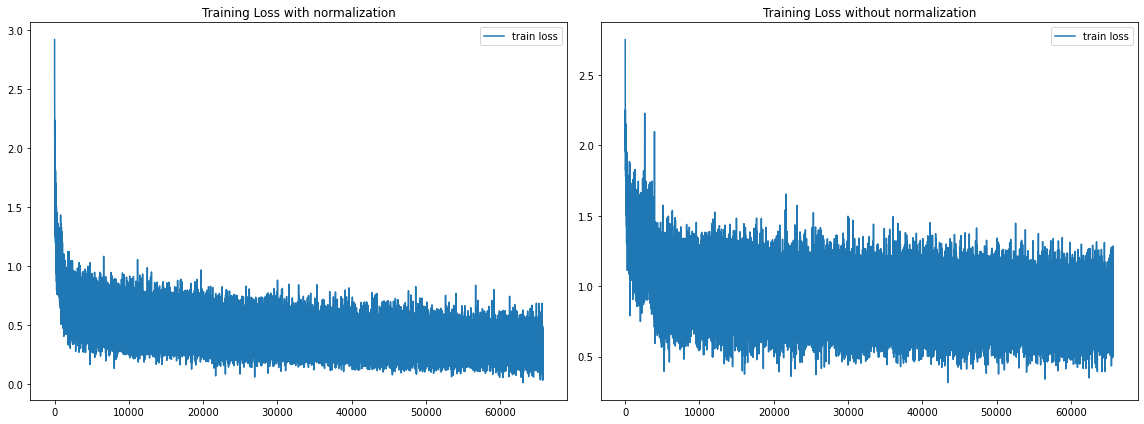

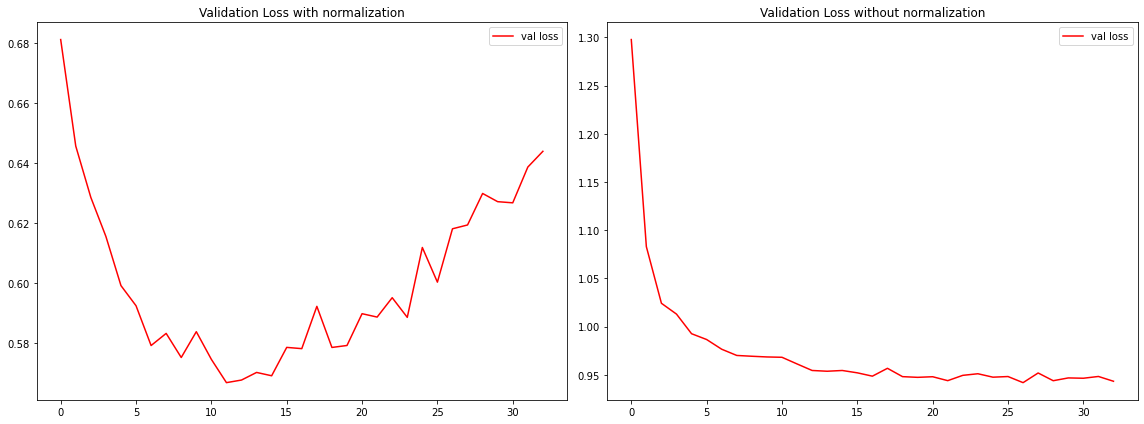

Accuracy with normalization: 0.7896666666666666
Accuracy without normalization: 0.6566666666666666


In [ ]:
from joblib import Parallel, delayed

def train_and_test(is_norm):
    model = MLP(ReLU, ReLU_derivative, valid_step=3)
    X_train = mnist_X_train if is_norm else mnist_X_train_nonorm
    y_train = mnist_y_train if is_norm else mnist_y_train_nonorm
    X_test = mnist_X_test if is_norm else mnist_X_test_nonorm
    y_test = mnist_y_test if is_norm else mnist_y_test_nonorm
    losses, _, _, val_losses, val_accuracies = model.fit(X_train, y_train, epochs=100, val_X=X_test, val_y=y_test)
    _, test_accuracy = model.calculate_metric_given_X(X_test, y_test)
    return losses, val_losses, test_accuracy

norms = [True, False]
names = ["with normalization", "without normalization"]

results = Parallel(n_jobs=2)(delayed(train_and_test)(is_norm) for is_norm in norms)

losses = [result[0] for result in results]
val_losses = [result[1] for result in results]
accuracies = [result[2] for result in results]

plt.figure(figsize=(16, 6))
for i in range(2):
    p = plt.subplot(1, 2, i+1)
    p.plot(losses[i], label='train loss')
    p.set_title(f"Training Loss {names[i]}")
    p.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
for i in range(2):
    p = plt.subplot(1, 2, i+1)
    p.plot(val_losses[i], label='val loss', color='red')
    p.set_title(f"Validation Loss {names[i]}")
    p.legend()
plt.tight_layout()
plt.show()

for i, acc in enumerate(accuracies):
    print(f"Accuracy {names[i]}: {acc}")

### Subtask 3.6: Test CNN (PyTorch) vs. our MLP on FashionMNIST

In [ ]:
import torch.nn.functional as F
import torch
class CNN_fashionMNIST(t.nn.Module):
    # need to create two classes for two datasets since the input shape is different
    def __init__(self):
        super(CNN_fashionMNIST, self).__init__()
        # input is N x 1 x 28 x 28
        self.conv1 = t.nn.Conv2d(1, 8, 5)
        # now dimension is N x 8 x (28 - 5 + 1) x (28 - 5 + 1) = N x 8 x 24 x 24; after 2x2 pooling it's N x 8 x 12 x 12
        self.conv2 = t.nn.Conv2d(8, 16, 3)
        # now dimension is N x 16 x (12 - 3 + 1) x (12 - 3 + 1) = N x 16 x 10 x 10; after 2x2 pooling it's N x 16 x 5 x 5
        self.fc1 = t.nn.Linear(16 * 5 * 5, 128)
        self.fc2 = t.nn.Linear(128, 128)
        # as demanded, we let the number of units to be 128 in fully-connected layers
        # number of classes is 10
        self.fc3 = t.nn.Linear(128, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))     # after convolution and applying ReLU activation, 8x24x24
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 8 x 12 x 12
        X = F.relu(self.conv2(X))     # after convolution and applying ReLU activation, 16x10x10
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 16 x 5 x 5
        # now, flatten X as we are going to use fully-connecter layers
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))       # after this layer, N x 128
        X = F.relu(self.fc2(X))       # still N x 128
        X = self.fc3(X)               # note that we didn't apply activation here in the last layer (unlike our implementation of MLP)
        return X

In [ ]:
# we will load the data again here since PyTorch CNN requires data in a different shape
from torch.utils.data import random_split

train_size = int(0.7 * len(mnist_train_df))
valid_size = int(0.2 * len(mnist_train_df))
test_size = len(mnist_train_df) - train_size - valid_size

mnist_train_dataset, mnist_train_dataset, mnist_test_dataset = random_split(mnist_train_df, [train_size, valid_size, test_size])
train_loader_mnist = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)
valid_loader_mnist = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=128, shuffle=False)
test_loader_mnist = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=128, shuffle=False)

mnist_train_loader = t.utils.data.DataLoader(mnist_train_dataset, batch_size=train_size, shuffle=True)
mnist_valid_loader = t.utils.data.DataLoader(mnist_valid_dataset, batch_size=valid_size, shuffle=False)
mnist_test_loader = t.utils.data.DataLoader(mnist_test_dataset, batch_size=test_size, shuffle=False)

mnist_X_train, mnist_y_train = next(iter(mnist_train_loader))
mnist_X_valid, mnist_y_valid = next(iter(mnist_valid_loader))
mnist_X_test, mnist_y_test = next(iter(mnist_test_loader))
mnist_X_train = np.asarray(mnist_X_train).reshape((train_size, -1))
mnist_y_train = np.asarray(mnist_y_train)
mnist_X_valid = np.asarray(mnist_X_valid).reshape((valid_size, -1))
mnist_y_valid = np.asarray(mnist_y_valid)
mnist_X_test = np.asarray(mnist_X_test).reshape((test_size, -1))
mnist_y_test = np.asarray(mnist_y_test)

Epoch 1/100, Validation Loss: 0.6722255070158776, Validation Accuracy: 0.7369166666666667
Epoch 2/100, Validation Loss: 0.5479228217551049, Validation Accuracy: 0.79375
Epoch 3/100, Validation Loss: 0.5136142867676755, Validation Accuracy: 0.7943333333333333
Epoch 4/100, Validation Loss: 0.48714007215296967, Validation Accuracy: 0.8203333333333334
Epoch 5/100, Validation Loss: 0.4276627758716015, Validation Accuracy: 0.84425
Epoch 6/100, Validation Loss: 0.405019259199183, Validation Accuracy: 0.851
Epoch 7/100, Validation Loss: 0.3692097399145999, Validation Accuracy: 0.8624166666666667
Epoch 8/100, Validation Loss: 0.3672585926474409, Validation Accuracy: 0.8641666666666666
Epoch 9/100, Validation Loss: 0.33367873712423, Validation Accuracy: 0.8783333333333333
Epoch 10/100, Validation Loss: 0.33329694844940877, Validation Accuracy: 0.8773333333333333
Epoch 11/100, Validation Loss: 0.30823428120384827, Validation Accuracy: 0.8864166666666666
Epoch 12/100, Validation Loss: 0.2890560447

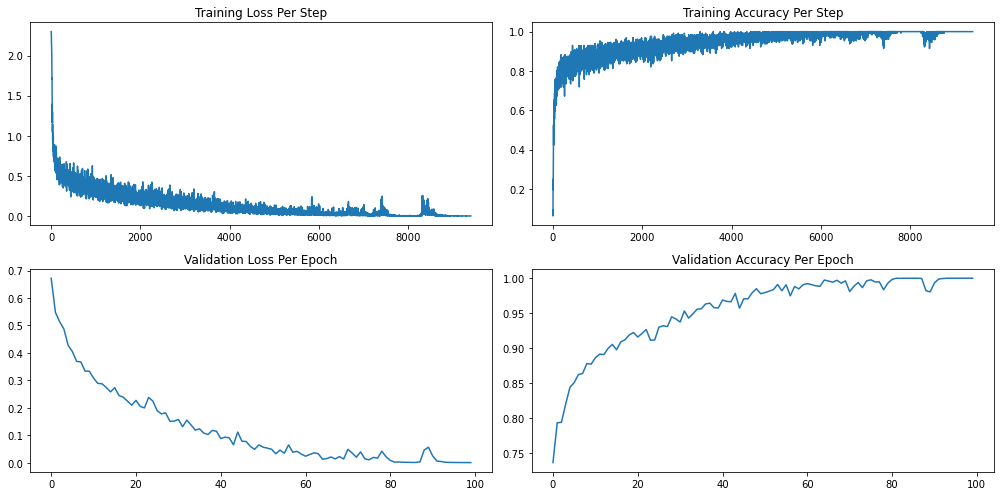

Test Loss: 0.9426115155220032, Test Accuracy: 0.8895


In [ ]:
# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_fashionMNIST().to(device)

loss_function = t.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(data_loader, model, loss_function, optimizer,valid_loader, epochs=10):
    model.train()
    loss_per_step = []
    accuracy_per_step = []
    valid_loss_epoch=[]
    valid_acc_epoch = []
    for epoch in range(epochs):
        for batch in data_loader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)

            _, prediction = torch.max(outputs, 1)
            correct = (prediction == y).sum().item()
            accuracy_per_step.append(correct / y.size(0))

            loss = loss_function(outputs, y)
            loss_per_step.append(loss.item())
            loss.backward()
            optimizer.step()


        valid_loss, valid_acc = validate(valid_loader, model, loss_function)
        valid_loss_epoch.append(valid_loss)
        valid_acc_epoch.append(valid_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")
    return loss_per_step, accuracy_per_step,valid_loss_epoch, valid_acc_epoch

def validate(data_loader, model, loss_function):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_function(outputs, y)
            total_loss += loss.item()
            _, prediction = torch.max(outputs, 1)
            correct += (prediction == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

loss_per_step, accuracy_per_step, valid_loss_per_epoch, valid_accuracy_per_epoch = train(train_loader_mnist, model, loss_function, optimizer, valid_loader_mnist,epochs=100)

# plot
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

axs[0, 0].plot(loss_per_step)
axs[0, 0].set_title("Training Loss Per Step")
axs[0, 1].plot(accuracy_per_step)
axs[0, 1].set_title("Training Accuracy Per Step")
axs[1, 0].plot(valid_loss_per_epoch)
axs[1, 0].set_title("Validation Loss Per Epoch")
axs[1, 1].plot(valid_accuracy_per_epoch)
axs[1, 1].set_title("Validation Accuracy Per Epoch")

plt.tight_layout()
plt.show()

test_loss, test_acc = validate(mnist_test_loader, model, loss_function)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

### Subtask 3.7: Test CNN (PyTorch) vs. our MLP on CIFAR-10

#### Revised version of MLP on CIFAR-10

In [ ]:
from torch.utils.data import random_split

# load the data in CIFAR-10 dataset
train_size = int(0.7 * len(cifar_train_df))
valid_size = int(0.2 * len(cifar_train_df))
test_size = len(cifar_train_df) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(cifar_train_df, [train_size, valid_size, test_size])

train_loader_cifar = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader_cifar = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader_cifar = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

train_iter = iter(train_loader)
cifar_X_train_tensor, cifar_y_train_tensor = next(train_iter)
cifar_X_train = cifar_X_train_tensor.numpy().reshape((train_size, -1))
cifar_y_train = cifar_y_train_tensor.numpy()

valid_iter = iter(valid_loader)
cifar_X_valid_tensor, cifar_y_valid_tensor = next(valid_iter)
cifar_X_valid = cifar_X_valid_tensor.numpy().reshape((valid_size, -1))
cifar_y_valid = cifar_y_valid_tensor.numpy()

test_iter = iter(test_loader)
cifar_X_test_tensor, cifar_y_test_tensor = next(test_iter)
cifar_X_test = cifar_X_test_tensor.numpy().reshape((test_size, -1))
cifar_y_test = cifar_y_test_tensor.numpy()

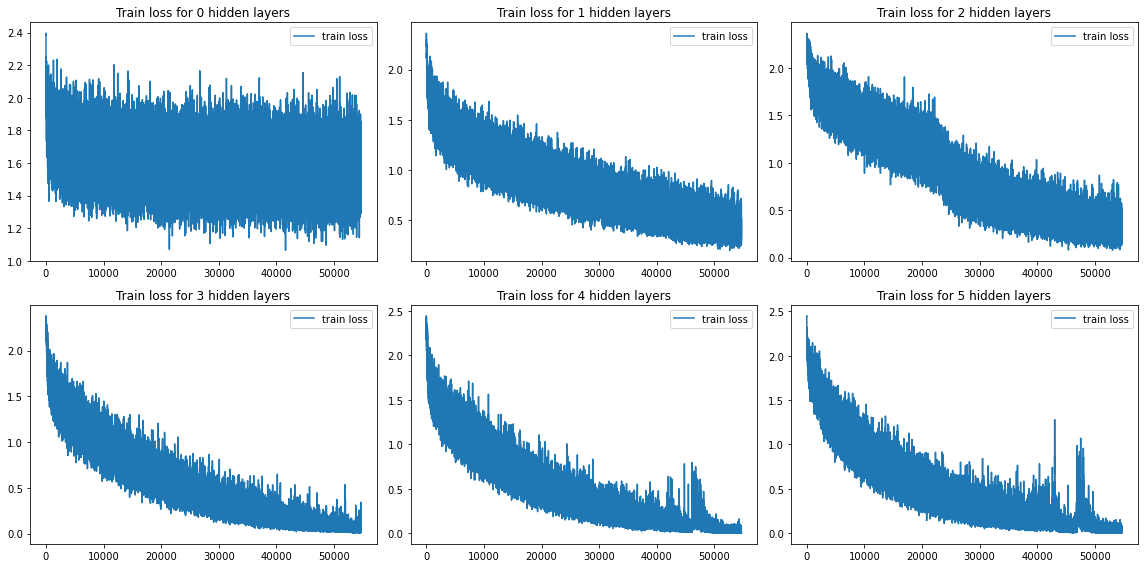

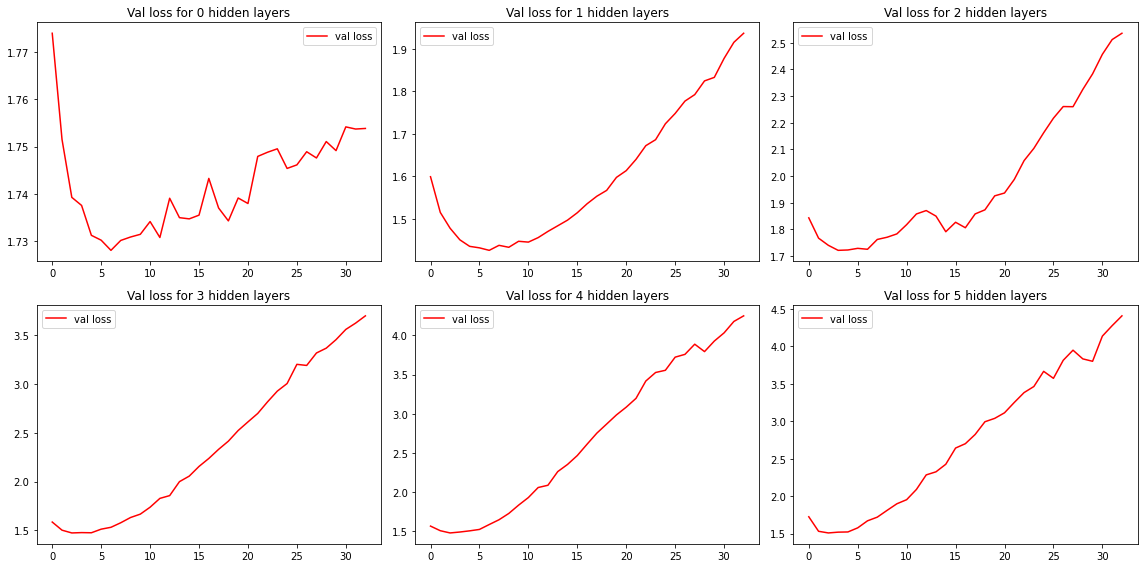

Test accuracy with 0 hidden layers: 0.394, Test loss with 0 hidden layers: [1.768787844299798, 1.984009880350892, 2.5597327197911914, 3.869378162817439, 4.242119592545994, 4.573447190370352]
Test accuracy with 1 hidden layers: 0.4816, Test loss with 1 hidden layers: [1.768787844299798, 1.984009880350892, 2.5597327197911914, 3.869378162817439, 4.242119592545994, 4.573447190370352]
Test accuracy with 2 hidden layers: 0.4728, Test loss with 2 hidden layers: [1.768787844299798, 1.984009880350892, 2.5597327197911914, 3.869378162817439, 4.242119592545994, 4.573447190370352]
Test accuracy with 3 hidden layers: 0.4648, Test loss with 3 hidden layers: [1.768787844299798, 1.984009880350892, 2.5597327197911914, 3.869378162817439, 4.242119592545994, 4.573447190370352]
Test accuracy with 4 hidden layers: 0.4796, Test loss with 4 hidden layers: [1.768787844299798, 1.984009880350892, 2.5597327197911914, 3.869378162817439, 4.242119592545994, 4.573447190370352]
Test accuracy with 5 hidden layers: 0.469

In [ ]:
from joblib import Parallel, delayed

def train_and_test(i):
    model = MLP(ReLU, ReLU_derivative, hidden=i, units=[128] * i, initializer="kaiming",valid_step=3)
    losses, _, _, val_losses, val_accuracies = model.fit(cifar_X_train, cifar_y_train, lr=0.01, epochs=100, val_X=cifar_X_valid, val_y=cifar_y_valid)
    test_loss, test_accuracy = model.test(cifar_X_test, cifar_y_test)
    return losses, val_losses, test_accuracy,test_loss

results = Parallel(n_jobs=6)(delayed(train_and_test)(i) for i in range(6))

losses = [result[0] for result in results]
val_losses = [result[1] for result in results]
accuracies = [result[2] for result in results]
test_losses = [result[3] for result in results]
plt.figure(figsize=(16, 8))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i], label='train loss')
    p.set_title("Train loss for {} hidden layers".format(i))
    p.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(val_losses[i], label='val loss', color='red')
    p.set_title("Val loss for {} hidden layers".format(i))
    p.legend()
plt.tight_layout()
plt.show()

for i, acc in enumerate(accuracies):
    print(f"Test accuracy with {i} hidden layers: {acc}, Test loss with {i} hidden layers: {test_losses}")

In [ ]:
# CNN: need to build another class since the dimension of images are different
class CNN_CIFAR10(t.nn.Module):
    def __init__(self):
        super(CNN_CIFAR10, self).__init__()
        # input is N x 3 x 32 x 32
        self.conv1 = t.nn.Conv2d(3, 16, 5)
        # now dimension is N x 16 x (32 - 5 + 1) x (32 - 5 + 1) = N x 16 x 28 x 28; after 2x2 pooling it's N x 16 x 14 x 14
        self.conv2 = t.nn.Conv2d(16, 32, 3)
        # now dimension is N x 32 x (14 - 3 + 1) x (14 - 3 + 1) = N x 32 x 12 x 12; after 2x2 pooling it's N x 32 x 6 x 6
        self.fc1 = t.nn.Linear(32 * 6 * 6, 128)
        self.fc2 = t.nn.Linear(128, 128)
        self.fc3 = t.nn.Linear(128, 10)
        # as demanded, we let the number of units to be 128 in fully-connected layers

    def forward(self, X):
        X = F.relu(self.conv1(X))     # after convolution and applying ReLU activation, 8x24x24
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 8 x 12 x 12
        X = F.relu(self.conv2(X))     # after convolution and applying ReLU activation, 16x10x10
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 16 x 5 x 5
        # now, flatten X as we are going to use fully-connecter layers
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))       # after this layer, N x 128
        X = F.relu(self.fc2(X))       # still N x 128
        X = self.fc3(X)               # note that we didn't apply activation here in the last layer (unlike our implementation of MLP)
        # number of classes is 10
        return X

#### Revised CNN on CIFAR-10

Epoch 1/100, Validation Loss: 2.299221781235707, Validation Accuracy: 0.1274
Epoch 2/100, Validation Loss: 2.289944748335247, Validation Accuracy: 0.1608
Epoch 3/100, Validation Loss: 2.2514837240870995, Validation Accuracy: 0.1885
Epoch 4/100, Validation Loss: 2.1025350199470036, Validation Accuracy: 0.2384
Epoch 5/100, Validation Loss: 1.9686195020434223, Validation Accuracy: 0.2946
Epoch 6/100, Validation Loss: 1.8920960109445113, Validation Accuracy: 0.3161
Epoch 7/100, Validation Loss: 1.9077682570566106, Validation Accuracy: 0.3152
Epoch 8/100, Validation Loss: 1.7940391166300713, Validation Accuracy: 0.3548
Epoch 9/100, Validation Loss: 1.6761302193508874, Validation Accuracy: 0.3838
Epoch 10/100, Validation Loss: 1.6319351301917546, Validation Accuracy: 0.4083
Epoch 11/100, Validation Loss: 1.5644454850426204, Validation Accuracy: 0.4368
Epoch 12/100, Validation Loss: 1.5384492496900921, Validation Accuracy: 0.4414
Epoch 13/100, Validation Loss: 1.5217745047581346, Validation A

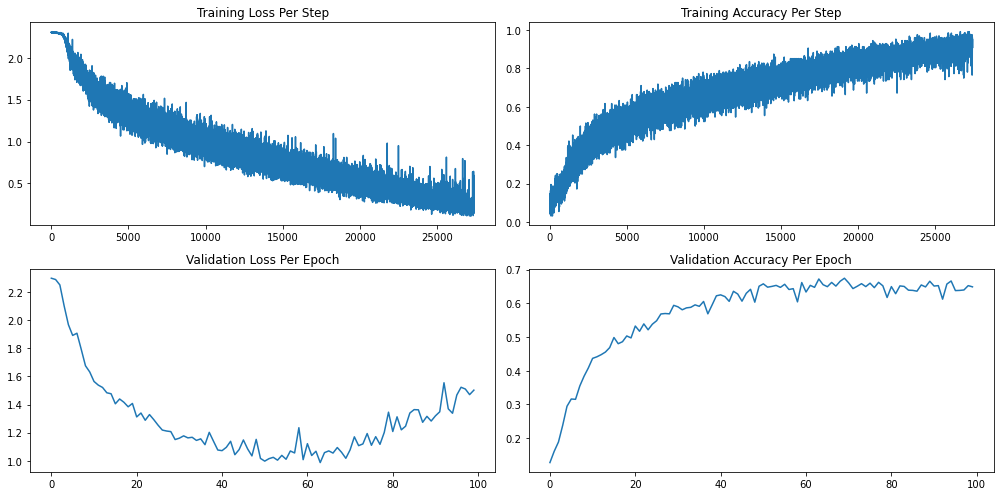

Test Loss: 1.4908718004822732, Test Accuracy: 0.6522


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cnn = CNN_CIFAR10().to(device)
loss_function_cnn = t.nn.CrossEntropyLoss()
optimizer_cnn = t.optim.SGD(model_cnn.parameters(), lr=0.01)        # note our lr in MLP and CNN are the same (0.01)

def train(data_loader, model, loss_function, optimizer,valid_loader, epochs=10):
    model.train()
    loss_per_step = []
    accuracy_per_step = []
    valid_loss_epoch=[]
    valid_acc_epoch = []
    for epoch in range(epochs):
        for batch in data_loader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)

            _, prediction = torch.max(outputs, 1)
            correct = (prediction == y).sum().item()
            accuracy_per_step.append(correct / y.size(0))

            loss = loss_function(outputs, y)
            loss_per_step.append(loss.item())
            loss.backward()
            optimizer.step()
        valid_loss, valid_acc = validate(valid_loader, model, loss_function)
        valid_loss_epoch.append(valid_loss)
        valid_acc_epoch.append(valid_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")

    return loss_per_step, accuracy_per_step,valid_loss_epoch, valid_acc_epoch

def validate(data_loader, model, loss_function):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_function(outputs, y)
            total_loss += loss.item()
            _, prediction = torch.max(outputs, 1)
            correct += (prediction == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

loss_per_step, accuracy_per_step, valid_loss_per_epoch, valid_accuracy_per_epoch = train(train_loader_cifar, model_cnn, loss_function_cnn, optimizer_cnn, valid_loader_cifar,epochs=100)

# plot
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

axs[0, 0].plot(loss_per_step)
axs[0, 0].set_title("Training Loss Per Step")
axs[0, 1].plot(accuracy_per_step)
axs[0, 1].set_title("Training Accuracy Per Step")
axs[1, 0].plot(valid_loss_per_epoch)
axs[1, 0].set_title("Validation Loss Per Epoch")
axs[1, 1].plot(valid_accuracy_per_epoch)
axs[1, 1].set_title("Validation Accuracy Per Epoch")

plt.tight_layout()
plt.show()

test_loss, test_acc = validate(test_loader_cifar, model_cnn, loss_function_cnn)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

### Subtask 3.8: Test the performance of SGD optimizer and Adam optimizer on CNN (PyTorch)

Epoch 1/50, Validation Loss: 2.298089090781876, Validation Accuracy: 0.1018
Epoch 2/50, Validation Loss: 2.2852521998972835, Validation Accuracy: 0.2027
Epoch 3/50, Validation Loss: 2.219726381422598, Validation Accuracy: 0.2035
Epoch 4/50, Validation Loss: 2.045204364800755, Validation Accuracy: 0.2507
Epoch 5/50, Validation Loss: 1.9190498681008061, Validation Accuracy: 0.3059
Epoch 6/50, Validation Loss: 1.8360731812972058, Validation Accuracy: 0.3333
Epoch 7/50, Validation Loss: 1.7490264690375026, Validation Accuracy: 0.3562
Epoch 8/50, Validation Loss: 1.6549713113639928, Validation Accuracy: 0.3938
Epoch 9/50, Validation Loss: 1.63994301270835, Validation Accuracy: 0.3887
Epoch 10/50, Validation Loss: 1.586566093601758, Validation Accuracy: 0.4249
Epoch 11/50, Validation Loss: 1.556805194178714, Validation Accuracy: 0.4282
Epoch 12/50, Validation Loss: 1.5359705399863328, Validation Accuracy: 0.4493
Epoch 13/50, Validation Loss: 1.467638057998464, Validation Accuracy: 0.4705
Epo

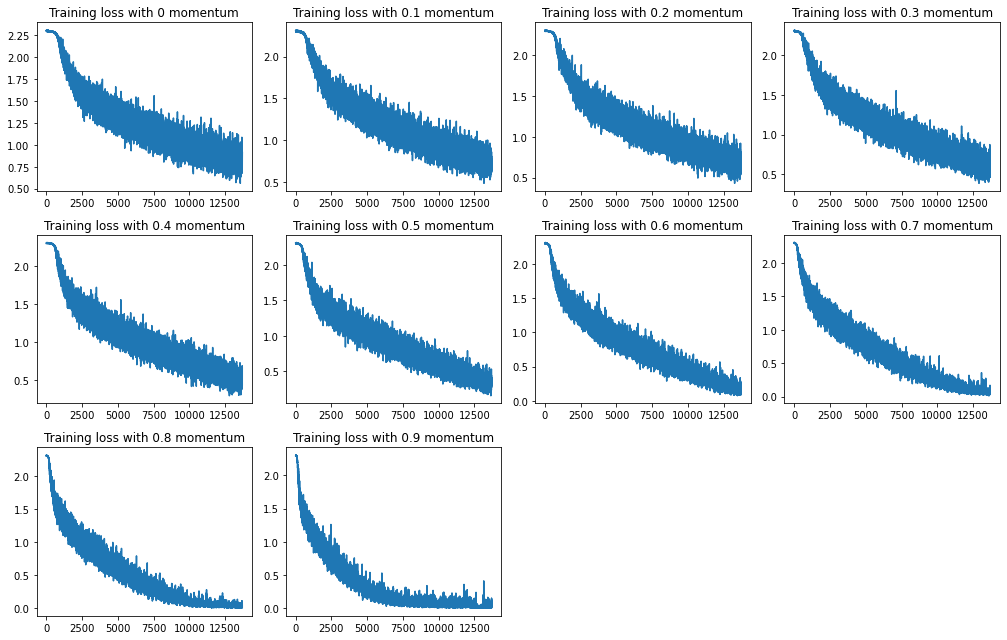

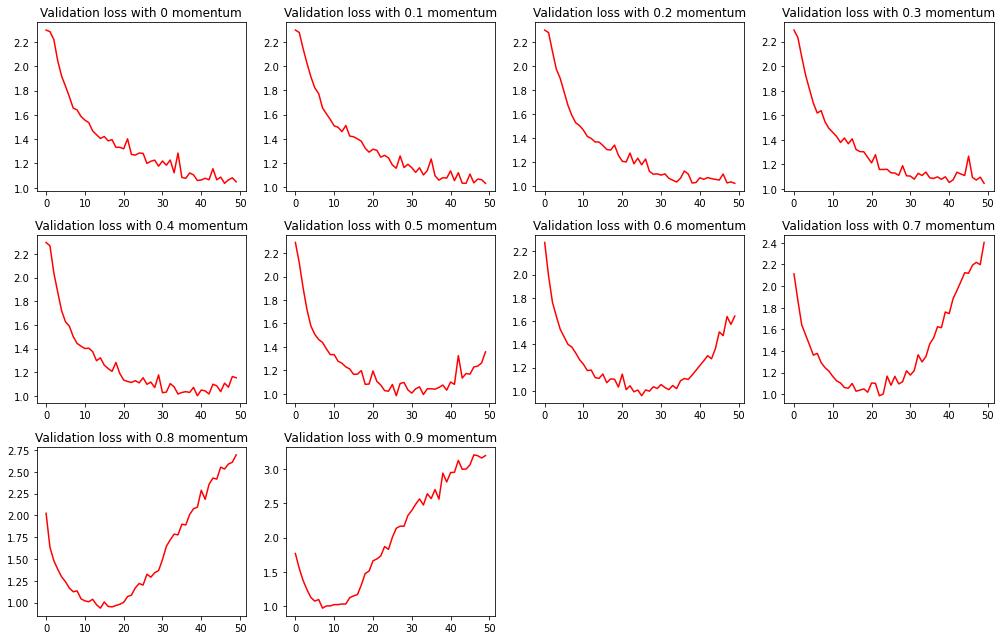

[0.6356, 0.6582, 0.6582, 0.6518, 0.6414, 0.6498, 0.6622, 0.6538, 0.6674, 0.6626]


In [ ]:
def train_and_test_momentum(beta):
    model_cnn_test = CNN_CIFAR10().to(device)
    loss_function_cnn = t.nn.CrossEntropyLoss()
    optimizer_cnn = t.optim.SGD(model_cnn_test.parameters(), lr=0.01, momentum=beta)
    loss_per_step, accuracy_per_step, valid_loss_per_epoch, valid_accuracy_per_epoch = train(train_loader_cifar, model_cnn_test, loss_function_cnn, optimizer_cnn, valid_loader_cifar,epochs=50)
    test_loss, test_accuracy = validate(test_loader_cifar, model_cnn_test, loss_function_cnn)
    return loss_per_step, test_accuracy,valid_loss_per_epoch

momentums = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_losses_sgd = []
accuracies_sgd = []
valid_losses_sgd = []

for beta in momentums:
    train_losses, test_accuracy,valid_losses = train_and_test_momentum(beta)
    train_losses_sgd.append(train_losses)
    accuracies_sgd.append(test_accuracy)
    valid_losses_sgd.append(valid_losses)

plt.figure(figsize=(14, 9))
for i in range(len(accuracies_sgd)):
    p = plt.subplot(3, 4, i+1)
    p.plot(train_losses_sgd[i])
    p.set_title("Training loss with {0} momentum".format(momentums[i]))
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 9))
for i in range(len(accuracies_sgd)):
    p = plt.subplot(3, 4, i+1)
    p.plot(valid_losses_sgd[i],color='red')
    p.set_title("Validation loss with {0} momentum".format(momentums[i]))
plt.tight_layout()
plt.show()

print(accuracies_sgd)

Epoch 1/50, Validation Loss: 1.6008093326906614, Validation Accuracy: 0.4217
Epoch 2/50, Validation Loss: 1.4836774883390982, Validation Accuracy: 0.4629
Epoch 3/50, Validation Loss: 1.3719684549524813, Validation Accuracy: 0.5057
Epoch 4/50, Validation Loss: 1.3711326756054842, Validation Accuracy: 0.5191
Epoch 5/50, Validation Loss: 1.3325894029834602, Validation Accuracy: 0.528
Epoch 6/50, Validation Loss: 1.2714090513277658, Validation Accuracy: 0.5488
Epoch 7/50, Validation Loss: 1.2544283640535572, Validation Accuracy: 0.5718
Epoch 8/50, Validation Loss: 1.299343237394019, Validation Accuracy: 0.5589
Epoch 9/50, Validation Loss: 1.306810148154633, Validation Accuracy: 0.5646
Epoch 10/50, Validation Loss: 1.251020900810821, Validation Accuracy: 0.5681
Epoch 11/50, Validation Loss: 1.3014695750007146, Validation Accuracy: 0.5559
Epoch 12/50, Validation Loss: 1.221457090558885, Validation Accuracy: 0.593
Epoch 13/50, Validation Loss: 1.2199225425720215, Validation Accuracy: 0.5859
E

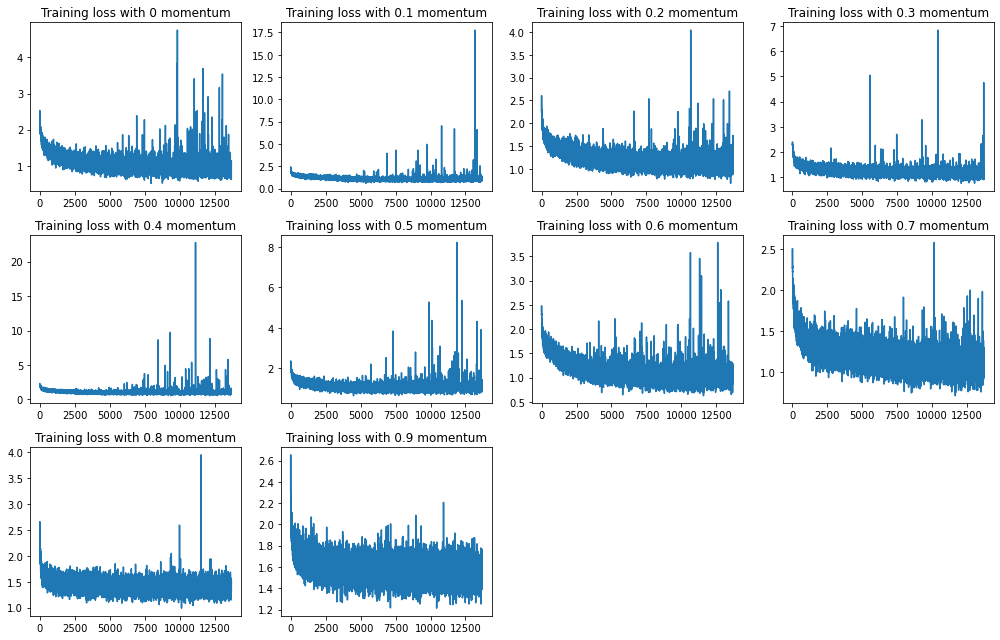

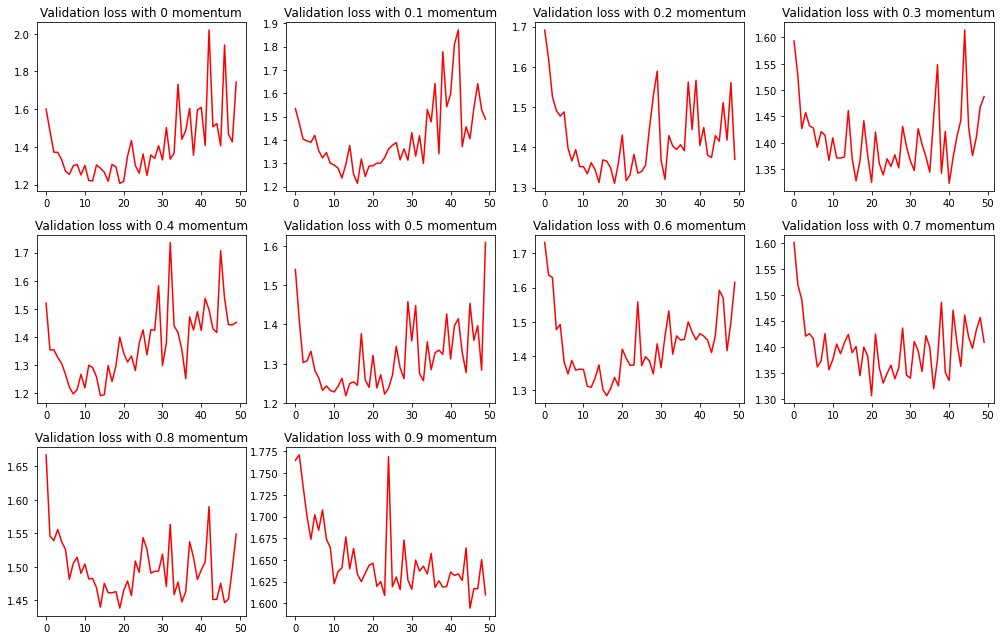

[0.59, 0.5742, 0.5512, 0.502, 0.5992, 0.5876, 0.5614, 0.562, 0.4528, 0.421]


In [ ]:
def train_and_test_momentum(beta):
    model_cnn_test = CNN_CIFAR10().to(device)
    loss_function_cnn = t.nn.CrossEntropyLoss()
    optimizer_cnn = t.optim.Adam(model_cnn_test.parameters(), lr=0.01, betas=(momentums[i], 0.9))

    loss_per_step, accuracy_per_step, valid_loss_per_epoch, valid_accuracy_per_epoch = train(train_loader_cifar, model_cnn_test, loss_function_cnn, optimizer_cnn, valid_loader_cifar,epochs=50)
    test_loss, test_accuracy = validate(test_loader_cifar, model_cnn_test, loss_function_cnn)

    return loss_per_step, test_accuracy,valid_loss_per_epoch

momentums = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_losses_sgd = []
accuracies_sgd = []
valid_losses_sgd = []

for beta in momentums:
    train_losses, test_accuracy,valid_losses = train_and_test_momentum(beta)
    train_losses_sgd.append(train_losses)
    accuracies_sgd.append(test_accuracy)
    valid_losses_sgd.append(valid_losses)

plt.figure(figsize=(14, 9))
for i in range(len(accuracies_sgd)):
    p = plt.subplot(3, 4, i+1)
    p.plot(train_losses_sgd[i])
    p.set_title("Training loss with {0} momentum".format(momentums[i]))
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 9))
for i in range(len(accuracies_sgd)):
    p = plt.subplot(3, 4, i+1)
    p.plot(valid_losses_sgd[i],color='red')
    p.set_title("Validation loss with {0} momentum".format(momentums[i]))
plt.tight_layout()
plt.show()

print(accuracies_sgd)

### Subtask 3.9 (Bonus): Test the behavior and performance of pre-trained model (ResNet)

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNet_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet_CIFAR10, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

Epoch 1/100, Validation Loss: 2.297081410130368, Validation Accuracy: 0.0975
Epoch 2/100, Validation Loss: 2.2825914666622498, Validation Accuracy: 0.1315
Epoch 3/100, Validation Loss: 2.2032959913905663, Validation Accuracy: 0.2062
Epoch 4/100, Validation Loss: 2.00210407263116, Validation Accuracy: 0.2827
Epoch 5/100, Validation Loss: 1.9238523003421253, Validation Accuracy: 0.3038
Epoch 6/100, Validation Loss: 1.860955090462407, Validation Accuracy: 0.3302
Epoch 7/100, Validation Loss: 1.790530342089979, Validation Accuracy: 0.3424
Epoch 8/100, Validation Loss: 1.7248975732658482, Validation Accuracy: 0.3687
Epoch 9/100, Validation Loss: 1.8059456786022912, Validation Accuracy: 0.349
Epoch 10/100, Validation Loss: 1.6288875945006744, Validation Accuracy: 0.4088
Epoch 11/100, Validation Loss: 1.5784016606173938, Validation Accuracy: 0.4219
Epoch 12/100, Validation Loss: 1.6410733476469788, Validation Accuracy: 0.4107
Epoch 13/100, Validation Loss: 1.5059902517101433, Validation Accur

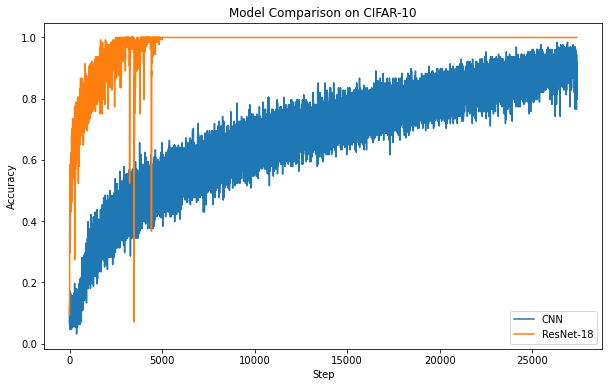

In [ ]:
import matplotlib.pyplot as plt

# Train and test CNN model
model_cnn = CNN_CIFAR10().to(device)
optimizer_cnn = t.optim.SGD(model_cnn.parameters(), lr=0.01)
loss_per_step_cnn, accuracy_per_step_cnn, valid_loss_per_epoch, valid_accuracy_per_epoch = train(train_loader_cifar, model_cnn, loss_function_cnn, optimizer_cnn, valid_loader_cifar,epochs=100)
test_loss_cnn, test_acc_cnn = validate(test_loader_cifar, model_cnn, loss_function_cnn)


# Train and test ResNet-18 model
model_resnet = ResNet_CIFAR10().to(device)
optimizer_resnet = t.optim.SGD(model_resnet.parameters(), lr=0.01)
loss_per_step_resnet, accuracy_per_step_resnet, valid_loss_per_epoch, valid_accuracy_per_epoch = train(train_loader_cifar, model_resnet, loss_function_cnn, optimizer_resnet, valid_loader_cifar,epochs=100)
test_loss_resnet, test_acc_resnet = validate(test_loader_cifar, model_resnet, loss_function_cnn)
print(f"Test Loss (ResNet-18): {test_loss_resnet}, Test Accuracy (ResNet-18): {test_acc_resnet}")
print(f"Test Loss (CNN): {test_loss_cnn}, Test Accuracy (CNN): {test_acc_cnn}")
# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(accuracy_per_step_cnn, label='CNN')
plt.plot(accuracy_per_step_resnet, label='ResNet-18')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Model Comparison on CIFAR-10')
plt.legend()
plt.show()